# Industrial Waste Sorting Systems

## Function to save Plots

In [6]:
# code to save the figures as high-res PNGs
import os
from pathlib import Path
from matplotlib import pyplot as plt

IMAGES_PATH = Path() / "Images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Split Dataset into Train/Validation/Test Sections

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_data(source_dir, dest_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    assert train_ratio + val_ratio + test_ratio == 1, "Train, val and test ratios must sum to 1."

    # Create destination directories
    for subset in ['train', 'val', 'test']:
        for class_name in ['Recyclable', 'Compostable', 'Landfill']:
            os.makedirs(os.path.join(dest_dir, subset, class_name), exist_ok=True)
    
    # Split and copy files
    for class_name in ['Recyclable', 'Compostable', 'Landfill']:
        class_path = os.path.join(source_dir, class_name)
        files = os.listdir(class_path)
        
        train_files, temp_files = train_test_split(files, train_size=train_ratio, random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=test_ratio/(val_ratio + test_ratio), random_state=42)

        for file_set, subset in zip([train_files, val_files, test_files], ['train', 'val', 'test']):
            for file in file_set:
                src = os.path.join(class_path, file)
                dst = os.path.join(dest_dir, subset, class_name, file)
                shutil.copy(src, dst)
                
    print('Dataset splitted successfully.')

source_dir = 'Dataset/'
dest_dir = 'Dataset/'
split_data(source_dir, dest_dir)

Dataset splitted successfully.


## Plot: Number of Images per Class Used for the System Development

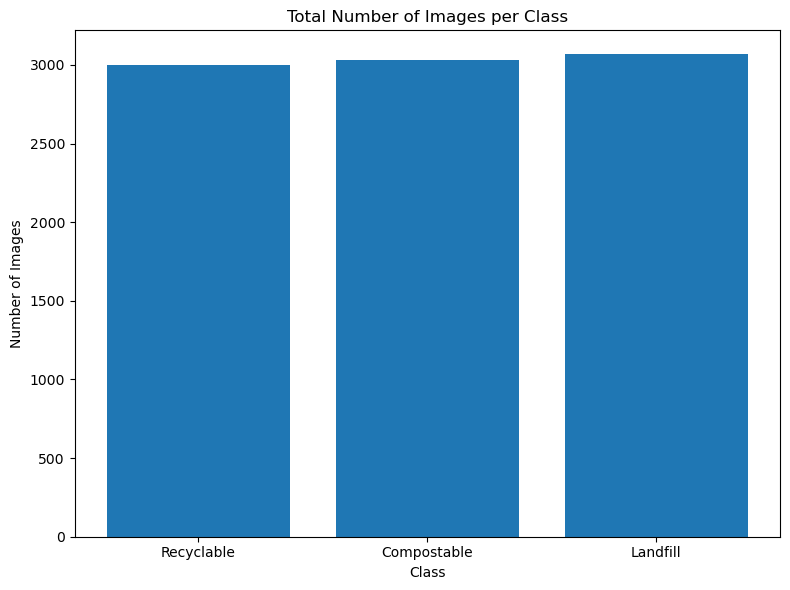

In [7]:
import os
import matplotlib.pyplot as plt

source_dir = 'Dataset/'
class_counts = {}

# List the folders (classes)
classes = ['Recyclable', 'Compostable', 'Landfill']

for class_name in classes:
    class_dir = os.path.join(source_dir, class_name)
    class_counts[class_name] = len([name for name in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, name))])

# Plotting the counts
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Total Number of Images per Class')
save_fig('Total Number of Images per Class')
plt.show()

## Plot: Images count per set

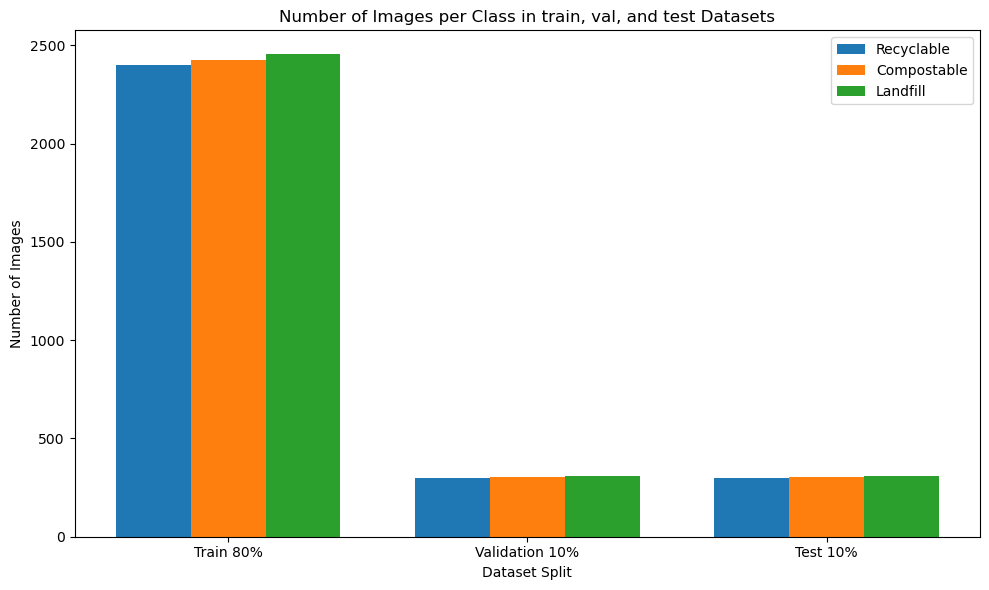

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt

# directories
directories = {
    'train': 'Dataset/train',
    'val': 'Dataset/val',
    'test': 'Dataset/test'
}

all_counts = {'Recyclable': [], 'Compostable': [], 'Landfill': []}

# Loop over the directories and classes
for dir_name, source_dir in directories.items():
    for class_name in all_counts.keys():
        class_dir = os.path.join(source_dir, class_name)
        # Count the number of images in the class folder
        count = len([name for name in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, name))])
        all_counts[class_name].append(count)

# Plotting the counts for each directory using bars
x_labels = ['Train 80%', 'Validation 10%', 'Test 10%']
x = np.arange(len(x_labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each class
for i, (class_name, counts) in enumerate(all_counts.items()):
    ax.bar(x + i*width, counts, width, label=class_name)

# Plot configs
ax.set_xlabel('Dataset Split')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class in train, val, and test Datasets')
ax.set_xticks(x + width)
ax.set_xticklabels(x_labels)
ax.legend()

# plt.grid(True)
save_fig('Train-Val-Test Count Plot')
plt.show()

## Pre-processing Section

### Dataloader Pipeline

In [16]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def create_train_val_test_dataloaders(data_dir, batch_size, num_workers=4):
    # Define specific transformations for each dataset
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((244, 244)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'val': transforms.Compose([
            transforms.Resize((244, 244)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'test': transforms.Compose([
            transforms.Resize((244, 244)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
    }

    # Create datasets using specific transformations
    image_datasets = {
        'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
        'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val']),
        'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])
    }

    # Create dataloaders
    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
        'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=num_workers),
        'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
    }

    return dataloaders

data_dir = 'Dataset/'
batch_size = 32
dataloaders = create_train_val_test_dataloaders(data_dir, batch_size)

# Accessing individual DataLoader objects
train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']

### Switching to GPU Utilization Mood

In [18]:
import torch
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Define CNN Models

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

def load_resnet50(num_classes):
    model =  models.resnet50(weights='ResNet50_Weights.DEFAULT')
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

def load_vgg19(num_classes):
    model = models.vgg19(weights='VGG19_Weights.DEFAULT')
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, num_classes)
    return model

### Model Training Section

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def train_model(model, dataloaders, criterion, optimizer, num_epochs, save_dir):
    global train_losses, val_losses, train_accuracies, val_accuracies
    
    # Create directory for saving models if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    train_loader = dataloaders['train']
    val_loader = dataloaders['val']

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)  # Output shape: [batch_size, num_classes]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_train_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = correct_val / total_val

        # Store loss and accuracy values
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Print epoch statistics
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%')

        # Save the model after each epoch
        torch.save(model.state_dict(), os.path.join(save_dir, f'model_epoch_{epoch+1}.pth'))

    print('Training complete.')

In [37]:
model = load_resnet50(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, dataloaders, criterion, optimizer, num_epochs=10, save_dir='Checkpoints/resnet50')

Epoch 1/10 - Validation: 100%|█████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.47it/s]


Epoch [1/10] - Train Loss: 0.4592, Train Acc: 83.28%, Val Loss: 0.3731, Val Acc: 87.69%


Epoch 2/10 - Validation: 100%|█████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.61it/s]


Epoch [2/10] - Train Loss: 0.2820, Train Acc: 90.01%, Val Loss: 0.2055, Val Acc: 92.31%


Epoch 3/10 - Validation: 100%|█████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.42it/s]


Epoch [3/10] - Train Loss: 0.2137, Train Acc: 92.13%, Val Loss: 0.6774, Val Acc: 80.77%


Epoch 4/10 - Validation: 100%|█████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.60it/s]


Epoch [4/10] - Train Loss: 0.2018, Train Acc: 92.42%, Val Loss: 0.2485, Val Acc: 90.99%


Epoch 5/10 - Validation: 100%|█████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.51it/s]


Epoch [5/10] - Train Loss: 0.1434, Train Acc: 94.84%, Val Loss: 0.2745, Val Acc: 89.89%


Epoch 6/10 - Validation: 100%|█████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.35it/s]


Epoch [6/10] - Train Loss: 0.1264, Train Acc: 95.49%, Val Loss: 0.2551, Val Acc: 90.00%


Epoch 7/10 - Validation: 100%|█████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.72it/s]


Epoch [7/10] - Train Loss: 0.1203, Train Acc: 95.45%, Val Loss: 0.4637, Val Acc: 85.16%


Epoch 8/10 - Validation: 100%|█████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.56it/s]


Epoch [8/10] - Train Loss: 0.1093, Train Acc: 96.57%, Val Loss: 0.2872, Val Acc: 88.35%


Epoch 9/10 - Validation: 100%|█████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.48it/s]


Epoch [9/10] - Train Loss: 0.0732, Train Acc: 97.45%, Val Loss: 0.1820, Val Acc: 91.98%


Epoch 10/10 - Validation: 100%|████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.53it/s]

Epoch [10/10] - Train Loss: 0.0815, Train Acc: 97.20%, Val Loss: 0.2059, Val Acc: 93.08%
Training complete.


### Plot: Learning Curve

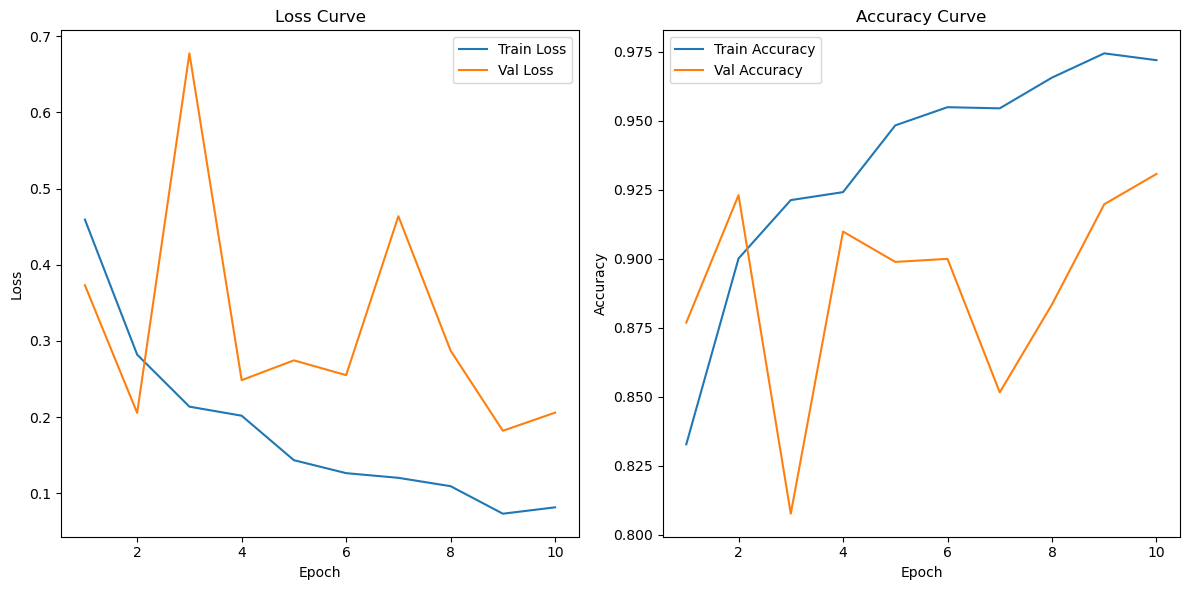

In [38]:
# Plot the learning curves
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
save_fig('learning curve')
plt.show()